In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[8].mean(dim=1).cpu().numpy())
    
    return np.vstack(hidden_states)


def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:11<00:00,  3.24it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 232/232 [00:05<00:00, 38.77it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:26<00:00,  2.81it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 243/243 [00:07<00:00, 34.35it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4864 and hidden_dim=256


Training Epochs:   0%|          | 9/2000 [00:05<19:19,  1.72it/s]

Epoch 10/2000, Loss: 0.6326
Test Accuracy at Epoch 10: 63.16%
Test F1-score at Epoch 10: 0.6667
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.68      0.52      0.59       194
non_infringement       0.60      0.75      0.67       186

        accuracy                           0.63       380
       macro avg       0.64      0.63      0.63       380
    weighted avg       0.64      0.63      0.63       380



Training Epochs:   0%|          | 10/2000 [00:05<21:12,  1.56it/s]

New best model saved with F1-score 0.6667 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.68      0.52      0.59       194
non_infringement       0.60      0.75      0.67       186

        accuracy                           0.63       380
       macro avg       0.64      0.63      0.63       380
    weighted avg       0.64      0.63      0.63       380



Training Epochs:   1%|          | 20/2000 [00:11<21:33,  1.53it/s]

Epoch 20/2000, Loss: 0.4799
Test Accuracy at Epoch 20: 70.26%
Test F1-score at Epoch 20: 0.7601
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.93      0.45      0.61       194
non_infringement       0.63      0.96      0.76       186

        accuracy                           0.70       380
       macro avg       0.78      0.71      0.68       380
    weighted avg       0.78      0.70      0.68       380

New best model saved with F1-score 0.7601 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.93      0.45      0.61       194
non_infringement       0.63      0.96      0.76       186

        accuracy                           0.70       380
       macro avg       0.78      0.71      0.68       380
    weighted avg       0.78      0.70      0.68       380



Training Epochs:   1%|▏         | 29/2000 [00:16<17:20,  1.89it/s]

Epoch 30/2000, Loss: 0.3963
Test Accuracy at Epoch 30: 75.26%
Test F1-score at Epoch 30: 0.7834
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.88      0.60      0.71       194
non_infringement       0.69      0.91      0.78       186

        accuracy                           0.75       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.75      0.75       380



Training Epochs:   2%|▏         | 30/2000 [00:19<34:55,  1.06s/it]

New best model saved with F1-score 0.7834 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.88      0.60      0.71       194
non_infringement       0.69      0.91      0.78       186

        accuracy                           0.75       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.75      0.75       380



Training Epochs:   2%|▏         | 39/2000 [00:22<11:10,  2.92it/s]

Epoch 40/2000, Loss: 0.3383
Test Accuracy at Epoch 40: 75.00%
Test F1-score at Epoch 40: 0.7875
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.92      0.56      0.70       194
non_infringement       0.67      0.95      0.79       186

        accuracy                           0.75       380
       macro avg       0.80      0.75      0.74       380
    weighted avg       0.80      0.75      0.74       380



Training Epochs:   2%|▏         | 40/2000 [00:23<23:25,  1.39it/s]

New best model saved with F1-score 0.7875 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.92      0.56      0.70       194
non_infringement       0.67      0.95      0.79       186

        accuracy                           0.75       380
       macro avg       0.80      0.75      0.74       380
    weighted avg       0.80      0.75      0.74       380



Training Epochs:   2%|▎         | 50/2000 [00:26<09:17,  3.50it/s]

Epoch 50/2000, Loss: 0.2975
Test Accuracy at Epoch 50: 79.47%
Test F1-score at Epoch 50: 0.8160
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380

New best model saved with F1-score 0.8160 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:   3%|▎         | 60/2000 [00:28<08:21,  3.87it/s]

Epoch 60/2000, Loss: 0.2608
Test Accuracy at Epoch 60: 78.16%
Test F1-score at Epoch 60: 0.8074
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.91      0.63      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:   3%|▎         | 69/2000 [00:30<03:54,  8.24it/s]

Epoch 70/2000, Loss: 0.2575
Test Accuracy at Epoch 70: 78.95%
Test F1-score at Epoch 70: 0.8010
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.85      0.72      0.78       194
non_infringement       0.75      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:   4%|▍         | 80/2000 [00:32<06:47,  4.71it/s]

Epoch 80/2000, Loss: 0.2144
Test Accuracy at Epoch 80: 79.21%
Test F1-score at Epoch 80: 0.8030
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.85      0.72      0.78       194
non_infringement       0.75      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:   5%|▍         | 91/2000 [00:37<11:30,  2.77it/s]

Epoch 90/2000, Loss: 0.2208
Test Accuracy at Epoch 90: 78.42%
Test F1-score at Epoch 90: 0.8111
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:   5%|▌         | 100/2000 [00:39<13:20,  2.37it/s]

Epoch 100/2000, Loss: 0.1906
Test Accuracy at Epoch 100: 77.89%
Test F1-score at Epoch 100: 0.7941
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.87      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:   6%|▌         | 110/2000 [00:43<14:32,  2.17it/s]

Epoch 110/2000, Loss: 0.1672
Test Accuracy at Epoch 110: 78.42%
Test F1-score at Epoch 110: 0.7950
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.84      0.72      0.77       194
non_infringement       0.74      0.85      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.79      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:   6%|▌         | 120/2000 [00:48<18:47,  1.67it/s]

Epoch 120/2000, Loss: 0.1710
Test Accuracy at Epoch 120: 79.47%
Test F1-score at Epoch 120: 0.8178
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.92      0.65      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380

New best model saved with F1-score 0.8178 at epoch 120
Best Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.92      0.65      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:   6%|▋         | 130/2000 [00:52<13:00,  2.40it/s]

Epoch 130/2000, Loss: 0.1723
Test Accuracy at Epoch 130: 77.37%
Test F1-score at Epoch 130: 0.7850
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.83      0.71      0.76       194
non_infringement       0.73      0.84      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.78      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:   7%|▋         | 140/2000 [00:55<09:00,  3.44it/s]

Epoch 140/2000, Loss: 0.1349
Test Accuracy at Epoch 140: 77.89%
Test F1-score at Epoch 140: 0.7981
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.87      0.67      0.76       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:   8%|▊         | 150/2000 [00:59<15:03,  2.05it/s]

Epoch 150/2000, Loss: 0.1290
Test Accuracy at Epoch 150: 79.21%
Test F1-score at Epoch 150: 0.8150
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:   8%|▊         | 164/2000 [01:01<02:35, 11.84it/s]

Epoch 160/2000, Loss: 0.1382
Test Accuracy at Epoch 160: 77.11%
Test F1-score at Epoch 160: 0.7841
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.83      0.70      0.76       194
non_infringement       0.73      0.85      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:   9%|▊         | 173/2000 [01:01<01:24, 21.71it/s]

Epoch 170/2000, Loss: 0.1224
Test Accuracy at Epoch 170: 78.95%
Test F1-score at Epoch 170: 0.8113
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.90      0.66      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:   9%|▉         | 187/2000 [01:01<01:00, 29.90it/s]

Epoch 180/2000, Loss: 0.1160
Test Accuracy at Epoch 180: 78.95%
Test F1-score at Epoch 180: 0.8113
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.90      0.66      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  10%|▉         | 192/2000 [01:01<00:54, 33.17it/s]

Epoch 190/2000, Loss: 0.1158
Test Accuracy at Epoch 190: 77.63%
Test F1-score at Epoch 190: 0.7952
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  10%|█         | 200/2000 [01:03<04:32,  6.60it/s]

Epoch 200/2000, Loss: 0.1386
Test Accuracy at Epoch 200: 78.16%
Test F1-score at Epoch 200: 0.8056
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.90      0.64      0.75       194
non_infringement       0.71      0.92      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  10%|█         | 210/2000 [01:08<13:12,  2.26it/s]

Epoch 210/2000, Loss: 0.1115
Test Accuracy at Epoch 210: 80.00%
Test F1-score at Epoch 210: 0.8173
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       194
non_infringement       0.74      0.91      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  11%|█         | 220/2000 [01:14<16:50,  1.76it/s]

Epoch 220/2000, Loss: 0.1101
Test Accuracy at Epoch 220: 78.95%
Test F1-score at Epoch 220: 0.8095
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.89      0.67      0.76       194
non_infringement       0.73      0.91      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  12%|█▏        | 230/2000 [01:19<15:40,  1.88it/s]

Epoch 230/2000, Loss: 0.1070
Test Accuracy at Epoch 230: 79.74%
Test F1-score at Epoch 230: 0.8153
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       194
non_infringement       0.74      0.91      0.82       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  12%|█▏        | 240/2000 [01:22<08:38,  3.39it/s]

Epoch 240/2000, Loss: 0.1077
Test Accuracy at Epoch 240: 77.37%
Test F1-score at Epoch 240: 0.8009
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.90      0.62      0.74       194
non_infringement       0.70      0.93      0.80       186

        accuracy                           0.77       380
       macro avg       0.80      0.78      0.77       380
    weighted avg       0.81      0.77      0.77       380



Training Epochs:  12%|█▎        | 250/2000 [01:28<16:46,  1.74it/s]

Epoch 250/2000, Loss: 0.1091
Test Accuracy at Epoch 250: 78.16%
Test F1-score at Epoch 250: 0.8083
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  13%|█▎        | 259/2000 [01:33<14:57,  1.94it/s]

Epoch 260/2000, Loss: 0.1072
Test Accuracy at Epoch 260: 80.00%
Test F1-score at Epoch 260: 0.8173


Training Epochs:  13%|█▎        | 260/2000 [01:33<17:41,  1.64it/s]

Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       194
non_infringement       0.74      0.91      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  14%|█▎        | 270/2000 [01:39<15:45,  1.83it/s]

Epoch 270/2000, Loss: 0.1029
Test Accuracy at Epoch 270: 79.21%
Test F1-score at Epoch 270: 0.8132
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.90      0.66      0.77       194
non_infringement       0.73      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  14%|█▍        | 280/2000 [01:44<16:00,  1.79it/s]

Epoch 280/2000, Loss: 0.0982
Test Accuracy at Epoch 280: 80.00%
Test F1-score at Epoch 280: 0.8173
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       194
non_infringement       0.74      0.91      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  14%|█▍        | 290/2000 [01:50<17:11,  1.66it/s]

Epoch 290/2000, Loss: 0.0963
Test Accuracy at Epoch 290: 80.26%
Test F1-score at Epoch 290: 0.8201
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.82      0.80      0.80       380

New best model saved with F1-score 0.8201 at epoch 290
Best Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  15%|█▍        | 299/2000 [01:55<15:42,  1.80it/s]

Epoch 300/2000, Loss: 0.0975
Test Accuracy at Epoch 300: 80.26%
Test F1-score at Epoch 300: 0.8184


Training Epochs:  15%|█▌        | 300/2000 [01:56<17:26,  1.62it/s]

Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.89      0.70      0.78       194
non_infringement       0.74      0.91      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  15%|█▌        | 309/2000 [02:01<15:42,  1.79it/s]

Epoch 310/2000, Loss: 0.0991
Test Accuracy at Epoch 310: 80.53%
Test F1-score at Epoch 310: 0.8213
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.89      0.70      0.79       194
non_infringement       0.75      0.91      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.82      0.81      0.80       380



Training Epochs:  16%|█▌        | 310/2000 [02:02<17:08,  1.64it/s]

New best model saved with F1-score 0.8213 at epoch 310
Best Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.89      0.70      0.79       194
non_infringement       0.75      0.91      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.82      0.81      0.80       380



Training Epochs:  16%|█▌        | 320/2000 [02:07<16:59,  1.65it/s]

Epoch 320/2000, Loss: 0.0955
Test Accuracy at Epoch 320: 80.53%
Test F1-score at Epoch 320: 0.8213
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.89      0.70      0.79       194
non_infringement       0.75      0.91      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.82      0.81      0.80       380



Training Epochs:  16%|█▋        | 329/2000 [02:12<15:29,  1.80it/s]

Epoch 330/2000, Loss: 0.0931
Test Accuracy at Epoch 330: 80.53%
Test F1-score at Epoch 330: 0.8230
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  16%|█▋        | 330/2000 [02:13<17:24,  1.60it/s]

New best model saved with F1-score 0.8230 at epoch 330
Best Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  17%|█▋        | 339/2000 [02:16<06:22,  4.34it/s]

Epoch 340/2000, Loss: 0.0912
Test Accuracy at Epoch 340: 80.79%
Test F1-score at Epoch 340: 0.8241
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.90      0.70      0.79       194
non_infringement       0.75      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  17%|█▋        | 340/2000 [02:17<08:50,  3.13it/s]

New best model saved with F1-score 0.8241 at epoch 340
Best Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.90      0.70      0.79       194
non_infringement       0.75      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  18%|█▊        | 350/2000 [02:21<07:36,  3.61it/s]

Epoch 350/2000, Loss: 0.0926
Test Accuracy at Epoch 350: 79.21%
Test F1-score at Epoch 350: 0.8150
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  18%|█▊        | 361/2000 [02:22<02:20, 11.70it/s]

Epoch 360/2000, Loss: 0.0963
Test Accuracy at Epoch 360: 80.79%
Test F1-score at Epoch 360: 0.8241
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.90      0.70      0.79       194
non_infringement       0.75      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  19%|█▊        | 371/2000 [02:23<01:49, 14.93it/s]

Epoch 370/2000, Loss: 0.0913
Test Accuracy at Epoch 370: 80.79%
Test F1-score at Epoch 370: 0.8241
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.90      0.70      0.79       194
non_infringement       0.75      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  19%|█▉        | 378/2000 [02:25<07:13,  3.75it/s]

Epoch 380/2000, Loss: 0.0864
Test Accuracy at Epoch 380: 81.05%
Test F1-score at Epoch 380: 0.8269
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  19%|█▉        | 380/2000 [03:18<4:33:25, 10.13s/it]

New best model saved with F1-score 0.8269 at epoch 380
Best Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  20%|█▉        | 390/2000 [03:23<25:50,  1.04it/s]  

Epoch 390/2000, Loss: 0.0856
Test Accuracy at Epoch 390: 80.53%
Test F1-score at Epoch 390: 0.8230
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  20%|██        | 401/2000 [03:26<04:38,  5.74it/s]

Epoch 400/2000, Loss: 0.0891
Test Accuracy at Epoch 400: 80.53%
Test F1-score at Epoch 400: 0.8230
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  21%|██        | 411/2000 [03:27<02:17, 11.56it/s]

Epoch 410/2000, Loss: 0.0907
Test Accuracy at Epoch 410: 80.26%
Test F1-score at Epoch 410: 0.8227
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.92      0.68      0.78       194
non_infringement       0.73      0.94      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  21%|██        | 420/2000 [03:30<10:23,  2.53it/s]

Epoch 420/2000, Loss: 0.0839
Test Accuracy at Epoch 420: 80.79%
Test F1-score at Epoch 420: 0.8249
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  22%|██▏       | 430/2000 [03:35<13:57,  1.88it/s]

Epoch 430/2000, Loss: 0.0833
Test Accuracy at Epoch 430: 82.63%
Test F1-score at Epoch 430: 0.8390
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.91      0.73      0.81       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.82       380

New best model saved with F1-score 0.8390 at epoch 430
Best Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.91      0.73      0.81       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.82       380



Training Epochs:  22%|██▏       | 440/2000 [03:37<03:49,  6.79it/s]

Epoch 440/2000, Loss: 0.0907
Test Accuracy at Epoch 440: 82.89%
Test F1-score at Epoch 440: 0.8403
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.91      0.74      0.82       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.83       380

New best model saved with F1-score 0.8403 at epoch 440
Best Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.91      0.74      0.82       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.83       380



Training Epochs:  23%|██▎       | 452/2000 [03:38<01:38, 15.76it/s]

Epoch 450/2000, Loss: 0.0922
Test Accuracy at Epoch 450: 79.74%
Test F1-score at Epoch 450: 0.8171
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.90      0.68      0.77       194
non_infringement       0.73      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  23%|██▎       | 462/2000 [03:38<01:24, 18.29it/s]

Epoch 460/2000, Loss: 0.0824
Test Accuracy at Epoch 460: 80.53%
Test F1-score at Epoch 460: 0.8230
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  24%|██▎       | 473/2000 [03:39<01:07, 22.66it/s]

Epoch 470/2000, Loss: 0.0830
Test Accuracy at Epoch 470: 83.16%
Test F1-score at Epoch 470: 0.8431
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.91      0.74      0.82       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.83       380

New best model saved with F1-score 0.8431 at epoch 470
Best Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.91      0.74      0.82       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.83       380



Training Epochs:  24%|██▍       | 479/2000 [03:39<02:04, 12.17it/s]

Epoch 480/2000, Loss: 0.0815
Test Accuracy at Epoch 480: 82.11%
Test F1-score at Epoch 480: 0.8350
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  25%|██▍       | 493/2000 [03:44<04:10,  6.02it/s]

Epoch 490/2000, Loss: 0.0998
Test Accuracy at Epoch 490: 78.68%
Test F1-score at Epoch 490: 0.8112
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.91      0.64      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  25%|██▍       | 498/2000 [03:44<02:29, 10.06it/s]

Epoch 500/2000, Loss: 0.0817
Test Accuracy at Epoch 500: 80.26%
Test F1-score at Epoch 500: 0.8219
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.91      0.68      0.78       194
non_infringement       0.74      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  26%|██▌       | 516/2000 [03:45<01:05, 22.58it/s]

Epoch 510/2000, Loss: 0.0812
Test Accuracy at Epoch 510: 81.58%
Test F1-score at Epoch 510: 0.8309
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.80       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.82      0.81       380



Training Epochs:  26%|██▌       | 523/2000 [03:45<01:06, 22.23it/s]

Epoch 520/2000, Loss: 0.0817
Test Accuracy at Epoch 520: 83.16%
Test F1-score at Epoch 520: 0.8431
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.91      0.74      0.82       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.83       380



Training Epochs:  26%|██▋       | 529/2000 [03:45<01:25, 17.29it/s]

Epoch 530/2000, Loss: 0.0804
Test Accuracy at Epoch 530: 81.84%
Test F1-score at Epoch 530: 0.8329
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  27%|██▋       | 544/2000 [03:47<01:44, 13.96it/s]

Epoch 540/2000, Loss: 0.0829
Test Accuracy at Epoch 540: 82.89%
Test F1-score at Epoch 540: 0.8403
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.91      0.74      0.82       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.83       380



Training Epochs:  28%|██▊       | 550/2000 [03:48<01:25, 16.88it/s]

Epoch 550/2000, Loss: 0.0827
Test Accuracy at Epoch 550: 81.58%
Test F1-score at Epoch 550: 0.8317
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.80       194
non_infringement       0.75      0.93      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.82      0.81       380



Training Epochs:  28%|██▊       | 560/2000 [03:51<05:59,  4.00it/s]

Epoch 560/2000, Loss: 0.0842
Test Accuracy at Epoch 560: 82.89%
Test F1-score at Epoch 560: 0.8403
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.91      0.74      0.82       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.83       380



Training Epochs:  28%|██▊       | 570/2000 [03:55<11:38,  2.05it/s]

Epoch 570/2000, Loss: 0.0798
Test Accuracy at Epoch 570: 82.89%
Test F1-score at Epoch 570: 0.8403
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.91      0.74      0.82       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.83       380



Training Epochs:  29%|██▉       | 580/2000 [04:01<13:58,  1.69it/s]

Epoch 580/2000, Loss: 0.0801
Test Accuracy at Epoch 580: 81.32%
Test F1-score at Epoch 580: 0.8281
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.90      0.71      0.80       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  30%|██▉       | 590/2000 [04:06<13:14,  1.77it/s]

Epoch 590/2000, Loss: 0.0795
Test Accuracy at Epoch 590: 82.37%
Test F1-score at Epoch 590: 0.8362
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  30%|███       | 600/2000 [04:12<13:18,  1.75it/s]

Epoch 600/2000, Loss: 0.0827
Test Accuracy at Epoch 600: 82.89%
Test F1-score at Epoch 600: 0.8403
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.91      0.74      0.82       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.83       380



Training Epochs:  30%|███       | 610/2000 [04:17<13:13,  1.75it/s]

Epoch 610/2000, Loss: 0.0860
Test Accuracy at Epoch 610: 80.79%
Test F1-score at Epoch 610: 0.8258
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.79       194
non_infringement       0.74      0.93      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  31%|███       | 620/2000 [04:23<14:22,  1.60it/s]

Epoch 620/2000, Loss: 0.0849
Test Accuracy at Epoch 620: 82.89%
Test F1-score at Epoch 620: 0.8403
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.91      0.74      0.82       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.83       380



Training Epochs:  32%|███▏      | 630/2000 [04:29<13:22,  1.71it/s]

Epoch 630/2000, Loss: 0.0785
Test Accuracy at Epoch 630: 82.37%
Test F1-score at Epoch 630: 0.8362
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  32%|███▏      | 640/2000 [04:34<13:34,  1.67it/s]

Epoch 640/2000, Loss: 0.0796
Test Accuracy at Epoch 640: 81.32%
Test F1-score at Epoch 640: 0.8281
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.90      0.71      0.80       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  32%|███▎      | 650/2000 [04:40<12:35,  1.79it/s]

Epoch 650/2000, Loss: 0.0790
Test Accuracy at Epoch 650: 82.37%
Test F1-score at Epoch 650: 0.8362
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  33%|███▎      | 660/2000 [04:45<12:04,  1.85it/s]

Epoch 660/2000, Loss: 0.0778
Test Accuracy at Epoch 660: 82.11%
Test F1-score at Epoch 660: 0.8341
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  34%|███▎      | 670/2000 [04:50<11:51,  1.87it/s]

Epoch 670/2000, Loss: 0.0783
Test Accuracy at Epoch 670: 81.32%
Test F1-score at Epoch 670: 0.8281
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.90      0.71      0.80       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  34%|███▍      | 680/2000 [04:55<12:16,  1.79it/s]

Epoch 680/2000, Loss: 0.0906
Test Accuracy at Epoch 680: 82.37%
Test F1-score at Epoch 680: 0.8362
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  34%|███▍      | 690/2000 [05:01<12:55,  1.69it/s]

Epoch 690/2000, Loss: 0.0830
Test Accuracy at Epoch 690: 82.37%
Test F1-score at Epoch 690: 0.8362
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  35%|███▌      | 700/2000 [05:06<12:44,  1.70it/s]

Epoch 700/2000, Loss: 0.0779
Test Accuracy at Epoch 700: 81.32%
Test F1-score at Epoch 700: 0.8281
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.90      0.71      0.80       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  36%|███▌      | 710/2000 [05:12<12:31,  1.72it/s]

Epoch 710/2000, Loss: 0.0782
Test Accuracy at Epoch 710: 81.32%
Test F1-score at Epoch 710: 0.8281
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.90      0.71      0.80       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  36%|███▌      | 720/2000 [05:18<12:41,  1.68it/s]

Epoch 720/2000, Loss: 0.0773
Test Accuracy at Epoch 720: 82.11%
Test F1-score at Epoch 720: 0.8341
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  36%|███▋      | 730/2000 [05:23<12:05,  1.75it/s]

Epoch 730/2000, Loss: 0.0771
Test Accuracy at Epoch 730: 81.84%
Test F1-score at Epoch 730: 0.8321
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  37%|███▋      | 740/2000 [05:29<11:53,  1.77it/s]

Epoch 740/2000, Loss: 0.0769
Test Accuracy at Epoch 740: 81.84%
Test F1-score at Epoch 740: 0.8321
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  38%|███▊      | 750/2000 [05:34<10:52,  1.92it/s]

Epoch 750/2000, Loss: 0.0767
Test Accuracy at Epoch 750: 82.11%
Test F1-score at Epoch 750: 0.8341
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  38%|███▊      | 760/2000 [05:39<11:05,  1.86it/s]

Epoch 760/2000, Loss: 0.0790
Test Accuracy at Epoch 760: 82.11%
Test F1-score at Epoch 760: 0.8333
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.77      0.91      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  39%|███▊      | 773/2000 [05:41<02:01, 10.13it/s]

Epoch 770/2000, Loss: 0.0873
Test Accuracy at Epoch 770: 80.26%
Test F1-score at Epoch 770: 0.8219
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.91      0.68      0.78       194
non_infringement       0.74      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  39%|███▉      | 782/2000 [05:41<01:10, 17.30it/s]

Epoch 780/2000, Loss: 0.0783
Test Accuracy at Epoch 780: 81.32%
Test F1-score at Epoch 780: 0.8297
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.93      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  40%|███▉      | 794/2000 [05:41<00:47, 25.22it/s]

Epoch 790/2000, Loss: 0.0767
Test Accuracy at Epoch 790: 81.32%
Test F1-score at Epoch 790: 0.8289
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  40%|████      | 804/2000 [05:42<01:27, 13.73it/s]

Epoch 800/2000, Loss: 0.0763
Test Accuracy at Epoch 800: 81.05%
Test F1-score at Epoch 800: 0.8261
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.90      0.71      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  41%|████      | 812/2000 [05:43<01:06, 17.85it/s]

Epoch 810/2000, Loss: 0.0763
Test Accuracy at Epoch 810: 81.84%
Test F1-score at Epoch 810: 0.8321
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  41%|████      | 824/2000 [05:43<01:01, 19.04it/s]

Epoch 820/2000, Loss: 0.0761
Test Accuracy at Epoch 820: 81.05%
Test F1-score at Epoch 820: 0.8261
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.90      0.71      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  42%|████▏     | 830/2000 [05:44<01:00, 19.19it/s]

Epoch 830/2000, Loss: 0.0776
Test Accuracy at Epoch 830: 81.05%
Test F1-score at Epoch 830: 0.8278
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.93      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  42%|████▏     | 843/2000 [05:44<00:49, 23.44it/s]

Epoch 840/2000, Loss: 0.0764
Test Accuracy at Epoch 840: 81.84%
Test F1-score at Epoch 840: 0.8321
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  43%|████▎     | 855/2000 [05:45<00:35, 32.12it/s]

Epoch 850/2000, Loss: 0.0802
Test Accuracy at Epoch 850: 81.05%
Test F1-score at Epoch 850: 0.8278
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.93      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  43%|████▎     | 868/2000 [05:45<00:31, 36.07it/s]

Epoch 860/2000, Loss: 0.0758
Test Accuracy at Epoch 860: 81.32%
Test F1-score at Epoch 860: 0.8289
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  44%|████▎     | 872/2000 [05:45<00:38, 29.40it/s]

Epoch 870/2000, Loss: 0.0762
Test Accuracy at Epoch 870: 81.84%
Test F1-score at Epoch 870: 0.8321
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  44%|████▍     | 879/2000 [05:48<03:34,  5.23it/s]

Epoch 880/2000, Loss: 0.0756
Test Accuracy at Epoch 880: 81.58%
Test F1-score at Epoch 880: 0.8301
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.82      0.81       380



Training Epochs:  44%|████▍     | 889/2000 [05:53<09:15,  2.00it/s]

Epoch 890/2000, Loss: 0.0757
Test Accuracy at Epoch 890: 81.84%
Test F1-score at Epoch 890: 0.8321


Training Epochs:  44%|████▍     | 890/2000 [05:54<10:28,  1.76it/s]

Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  45%|████▌     | 900/2000 [06:00<10:14,  1.79it/s]

Epoch 900/2000, Loss: 0.0783
Test Accuracy at Epoch 900: 82.11%
Test F1-score at Epoch 900: 0.8333
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.77      0.91      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  46%|████▌     | 910/2000 [06:06<10:49,  1.68it/s]

Epoch 910/2000, Loss: 0.0765
Test Accuracy at Epoch 910: 81.05%
Test F1-score at Epoch 910: 0.8278
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.93      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  46%|████▌     | 920/2000 [06:11<10:39,  1.69it/s]

Epoch 920/2000, Loss: 0.0786
Test Accuracy at Epoch 920: 82.37%
Test F1-score at Epoch 920: 0.8362
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  46%|████▋     | 930/2000 [06:17<10:58,  1.62it/s]

Epoch 930/2000, Loss: 0.0760
Test Accuracy at Epoch 930: 81.32%
Test F1-score at Epoch 930: 0.8297
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.93      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  47%|████▋     | 940/2000 [06:23<10:45,  1.64it/s]

Epoch 940/2000, Loss: 0.0753
Test Accuracy at Epoch 940: 81.05%
Test F1-score at Epoch 940: 0.8278
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.93      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  47%|████▋     | 949/2000 [06:28<09:56,  1.76it/s]

Epoch 950/2000, Loss: 0.0753
Test Accuracy at Epoch 950: 81.84%
Test F1-score at Epoch 950: 0.8321
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  48%|████▊     | 960/2000 [06:34<10:00,  1.73it/s]

Epoch 960/2000, Loss: 0.0750
Test Accuracy at Epoch 960: 81.84%
Test F1-score at Epoch 960: 0.8329
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  48%|████▊     | 970/2000 [06:40<09:58,  1.72it/s]

Epoch 970/2000, Loss: 0.0749
Test Accuracy at Epoch 970: 81.84%
Test F1-score at Epoch 970: 0.8329
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  49%|████▉     | 980/2000 [06:45<10:21,  1.64it/s]

Epoch 980/2000, Loss: 0.0879
Test Accuracy at Epoch 980: 82.37%
Test F1-score at Epoch 980: 0.8354
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.90      0.74      0.81       194
non_infringement       0.77      0.91      0.84       186

        accuracy                           0.82       380
       macro avg       0.83      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  50%|████▉     | 990/2000 [06:51<10:14,  1.64it/s]

Epoch 990/2000, Loss: 0.0772
Test Accuracy at Epoch 990: 82.11%
Test F1-score at Epoch 990: 0.8333
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.77      0.91      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  50%|█████     | 1000/2000 [06:57<09:46,  1.70it/s]

Epoch 1000/2000, Loss: 0.0763
Test Accuracy at Epoch 1000: 81.84%
Test F1-score at Epoch 1000: 0.8321
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  50%|█████     | 1010/2000 [07:02<09:48,  1.68it/s]

Epoch 1010/2000, Loss: 0.0755
Test Accuracy at Epoch 1010: 81.84%
Test F1-score at Epoch 1010: 0.8329
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  51%|█████     | 1020/2000 [07:08<09:53,  1.65it/s]

Epoch 1020/2000, Loss: 0.0750
Test Accuracy at Epoch 1020: 81.84%
Test F1-score at Epoch 1020: 0.8329
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  52%|█████▏    | 1030/2000 [07:14<09:32,  1.70it/s]

Epoch 1030/2000, Loss: 0.0748
Test Accuracy at Epoch 1030: 81.84%
Test F1-score at Epoch 1030: 0.8329
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  52%|█████▏    | 1040/2000 [07:19<08:41,  1.84it/s]

Epoch 1040/2000, Loss: 0.0747
Test Accuracy at Epoch 1040: 81.58%
Test F1-score at Epoch 1040: 0.8309
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.80       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.82      0.81       380



Training Epochs:  52%|█████▎    | 1050/2000 [07:24<08:12,  1.93it/s]

Epoch 1050/2000, Loss: 0.0747
Test Accuracy at Epoch 1050: 81.84%
Test F1-score at Epoch 1050: 0.8329
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  53%|█████▎    | 1060/2000 [07:28<06:15,  2.51it/s]

Epoch 1060/2000, Loss: 0.0746
Test Accuracy at Epoch 1060: 81.84%
Test F1-score at Epoch 1060: 0.8329
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  53%|█████▎    | 1068/2000 [07:28<02:12,  7.04it/s]

Epoch 1070/2000, Loss: 0.0800
Test Accuracy at Epoch 1070: 82.11%
Test F1-score at Epoch 1070: 0.8333
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.77      0.91      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  54%|█████▍    | 1080/2000 [07:29<01:00, 15.21it/s]

Epoch 1080/2000, Loss: 0.0785
Test Accuracy at Epoch 1080: 81.32%
Test F1-score at Epoch 1080: 0.8305
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.79       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  55%|█████▍    | 1092/2000 [07:30<01:05, 13.94it/s]

Epoch 1090/2000, Loss: 0.0765
Test Accuracy at Epoch 1090: 81.32%
Test F1-score at Epoch 1090: 0.8305
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.79       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  55%|█████▌    | 1104/2000 [07:31<00:39, 22.60it/s]

Epoch 1100/2000, Loss: 0.0751
Test Accuracy at Epoch 1100: 81.84%
Test F1-score at Epoch 1100: 0.8345
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  56%|█████▌    | 1112/2000 [07:31<00:33, 26.84it/s]

Epoch 1110/2000, Loss: 0.0747
Test Accuracy at Epoch 1110: 82.11%
Test F1-score at Epoch 1110: 0.8365
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  56%|█████▌    | 1120/2000 [07:31<00:31, 27.66it/s]

Epoch 1120/2000, Loss: 0.0746
Test Accuracy at Epoch 1120: 81.84%
Test F1-score at Epoch 1120: 0.8345
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  57%|█████▋    | 1136/2000 [07:32<00:27, 31.24it/s]

Epoch 1130/2000, Loss: 0.0745
Test Accuracy at Epoch 1130: 81.84%
Test F1-score at Epoch 1130: 0.8345
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  57%|█████▋    | 1145/2000 [07:32<00:26, 31.83it/s]

Epoch 1140/2000, Loss: 0.0744
Test Accuracy at Epoch 1140: 82.37%
Test F1-score at Epoch 1140: 0.8386
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.92      0.72      0.81       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  58%|█████▊    | 1152/2000 [07:32<00:34, 24.93it/s]

Epoch 1150/2000, Loss: 0.0745
Test Accuracy at Epoch 1150: 82.37%
Test F1-score at Epoch 1150: 0.8386
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.92      0.72      0.81       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  58%|█████▊    | 1164/2000 [07:33<00:36, 23.03it/s]

Epoch 1160/2000, Loss: 0.0801
Test Accuracy at Epoch 1160: 82.37%
Test F1-score at Epoch 1160: 0.8362
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  59%|█████▊    | 1174/2000 [07:33<00:31, 26.22it/s]

Epoch 1170/2000, Loss: 0.0794
Test Accuracy at Epoch 1170: 81.32%
Test F1-score at Epoch 1170: 0.8305
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.79       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  59%|█████▉    | 1185/2000 [07:34<00:27, 29.94it/s]

Epoch 1180/2000, Loss: 0.0755
Test Accuracy at Epoch 1180: 81.32%
Test F1-score at Epoch 1180: 0.8305
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.79       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  60%|█████▉    | 1193/2000 [07:34<00:27, 29.85it/s]

Epoch 1190/2000, Loss: 0.0744
Test Accuracy at Epoch 1190: 81.84%
Test F1-score at Epoch 1190: 0.8345
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  60%|██████    | 1202/2000 [07:34<00:26, 30.65it/s]

Epoch 1200/2000, Loss: 0.0745
Test Accuracy at Epoch 1200: 82.11%
Test F1-score at Epoch 1200: 0.8365
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  61%|██████    | 1216/2000 [07:35<00:28, 27.35it/s]

Epoch 1210/2000, Loss: 0.0744
Test Accuracy at Epoch 1210: 82.11%
Test F1-score at Epoch 1210: 0.8365
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  61%|██████    | 1220/2000 [07:36<01:00, 12.89it/s]

Epoch 1220/2000, Loss: 0.0743
Test Accuracy at Epoch 1220: 81.84%
Test F1-score at Epoch 1220: 0.8345
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  62%|██████▏   | 1233/2000 [07:37<00:55, 13.77it/s]

Epoch 1230/2000, Loss: 0.0744
Test Accuracy at Epoch 1230: 81.84%
Test F1-score at Epoch 1230: 0.8345
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  62%|██████▏   | 1242/2000 [07:37<00:42, 17.77it/s]

Epoch 1240/2000, Loss: 0.0790
Test Accuracy at Epoch 1240: 81.58%
Test F1-score at Epoch 1240: 0.8333
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.79       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  63%|██████▎   | 1257/2000 [07:38<00:34, 21.30it/s]

Epoch 1250/2000, Loss: 0.0780
Test Accuracy at Epoch 1250: 82.63%
Test F1-score at Epoch 1250: 0.8398
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.92      0.73      0.81       194
non_infringement       0.77      0.93      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.82       380



Training Epochs:  63%|██████▎   | 1260/2000 [07:38<00:36, 20.18it/s]

Epoch 1260/2000, Loss: 0.0753
Test Accuracy at Epoch 1260: 81.84%
Test F1-score at Epoch 1260: 0.8345
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  64%|██████▎   | 1273/2000 [07:39<00:36, 20.10it/s]

Epoch 1270/2000, Loss: 0.0748
Test Accuracy at Epoch 1270: 81.84%
Test F1-score at Epoch 1270: 0.8345
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  64%|██████▍   | 1284/2000 [07:39<00:29, 24.33it/s]

Epoch 1280/2000, Loss: 0.0743
Test Accuracy at Epoch 1280: 82.11%
Test F1-score at Epoch 1280: 0.8365
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  65%|██████▍   | 1292/2000 [07:40<00:25, 27.57it/s]

Epoch 1290/2000, Loss: 0.0742
Test Accuracy at Epoch 1290: 82.11%
Test F1-score at Epoch 1290: 0.8365
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  65%|██████▌   | 1302/2000 [07:40<00:24, 28.07it/s]

Epoch 1300/2000, Loss: 0.0742
Test Accuracy at Epoch 1300: 82.11%
Test F1-score at Epoch 1300: 0.8365
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  66%|██████▌   | 1314/2000 [07:41<00:23, 29.74it/s]

Epoch 1310/2000, Loss: 0.0742
Test Accuracy at Epoch 1310: 81.84%
Test F1-score at Epoch 1310: 0.8345
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  66%|██████▋   | 1327/2000 [07:41<00:20, 33.38it/s]

Epoch 1320/2000, Loss: 0.0803
Test Accuracy at Epoch 1320: 81.05%
Test F1-score at Epoch 1320: 0.8302
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.93      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  67%|██████▋   | 1336/2000 [07:41<00:21, 31.32it/s]

Epoch 1330/2000, Loss: 0.0790
Test Accuracy at Epoch 1330: 82.37%
Test F1-score at Epoch 1330: 0.8386
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.92      0.72      0.81       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  67%|██████▋   | 1344/2000 [07:42<00:22, 28.89it/s]

Epoch 1340/2000, Loss: 0.0761
Test Accuracy at Epoch 1340: 82.37%
Test F1-score at Epoch 1340: 0.8386
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.92      0.72      0.81       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  68%|██████▊   | 1353/2000 [07:42<00:19, 32.68it/s]

Epoch 1350/2000, Loss: 0.0750
Test Accuracy at Epoch 1350: 82.11%
Test F1-score at Epoch 1350: 0.8365
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  68%|██████▊   | 1365/2000 [07:42<00:19, 32.75it/s]

Epoch 1360/2000, Loss: 0.0745
Test Accuracy at Epoch 1360: 82.11%
Test F1-score at Epoch 1360: 0.8365
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  69%|██████▊   | 1373/2000 [07:42<00:21, 28.99it/s]

Epoch 1370/2000, Loss: 0.0743
Test Accuracy at Epoch 1370: 82.11%
Test F1-score at Epoch 1370: 0.8365
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  69%|██████▉   | 1385/2000 [07:43<00:20, 29.97it/s]

Epoch 1380/2000, Loss: 0.0742
Test Accuracy at Epoch 1380: 82.11%
Test F1-score at Epoch 1380: 0.8365
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  70%|██████▉   | 1393/2000 [07:43<00:21, 28.73it/s]

Epoch 1390/2000, Loss: 0.0741
Test Accuracy at Epoch 1390: 82.11%
Test F1-score at Epoch 1390: 0.8373
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  70%|███████   | 1402/2000 [07:43<00:17, 33.63it/s]

Epoch 1400/2000, Loss: 0.0741
Test Accuracy at Epoch 1400: 82.11%
Test F1-score at Epoch 1400: 0.8373
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  70%|███████   | 1410/2000 [07:44<00:22, 26.16it/s]

Epoch 1410/2000, Loss: 0.0745
Test Accuracy at Epoch 1410: 82.11%
Test F1-score at Epoch 1410: 0.8373
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  71%|███████   | 1422/2000 [07:44<00:27, 20.76it/s]

Epoch 1420/2000, Loss: 0.0743
Test Accuracy at Epoch 1420: 82.37%
Test F1-score at Epoch 1420: 0.8386
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.92      0.72      0.81       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  72%|███████▏  | 1435/2000 [07:45<00:23, 23.58it/s]

Epoch 1430/2000, Loss: 0.0773
Test Accuracy at Epoch 1430: 81.58%
Test F1-score at Epoch 1430: 0.8333
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.79       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  72%|███████▏  | 1447/2000 [07:45<00:19, 28.43it/s]

Epoch 1440/2000, Loss: 0.0751
Test Accuracy at Epoch 1440: 82.11%
Test F1-score at Epoch 1440: 0.8373
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  73%|███████▎  | 1456/2000 [07:46<00:20, 26.59it/s]

Epoch 1450/2000, Loss: 0.0744
Test Accuracy at Epoch 1450: 82.11%
Test F1-score at Epoch 1450: 0.8373
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  73%|███████▎  | 1465/2000 [07:46<00:17, 29.85it/s]

Epoch 1460/2000, Loss: 0.0741
Test Accuracy at Epoch 1460: 82.11%
Test F1-score at Epoch 1460: 0.8373
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  74%|███████▎  | 1474/2000 [07:46<00:17, 30.83it/s]

Epoch 1470/2000, Loss: 0.0741
Test Accuracy at Epoch 1470: 82.37%
Test F1-score at Epoch 1470: 0.8393
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  74%|███████▍  | 1483/2000 [07:47<00:16, 32.11it/s]

Epoch 1480/2000, Loss: 0.0741
Test Accuracy at Epoch 1480: 82.37%
Test F1-score at Epoch 1480: 0.8393
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  75%|███████▍  | 1493/2000 [07:47<00:20, 24.46it/s]

Epoch 1490/2000, Loss: 0.0741
Test Accuracy at Epoch 1490: 82.37%
Test F1-score at Epoch 1490: 0.8393
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  75%|███████▌  | 1502/2000 [07:47<00:15, 31.38it/s]

Epoch 1500/2000, Loss: 0.0743
Test Accuracy at Epoch 1500: 82.37%
Test F1-score at Epoch 1500: 0.8393
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  76%|███████▌  | 1511/2000 [07:48<00:43, 11.19it/s]

Epoch 1510/2000, Loss: 0.0750
Test Accuracy at Epoch 1510: 82.37%
Test F1-score at Epoch 1510: 0.8393
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  76%|███████▌  | 1520/2000 [07:50<00:53,  9.03it/s]

Epoch 1520/2000, Loss: 0.0752
Test Accuracy at Epoch 1520: 82.63%
Test F1-score at Epoch 1520: 0.8413
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.85      0.83      0.82       380



Training Epochs:  77%|███████▋  | 1532/2000 [07:50<00:34, 13.70it/s]

Epoch 1530/2000, Loss: 0.0743
Test Accuracy at Epoch 1530: 82.37%
Test F1-score at Epoch 1530: 0.8393
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  77%|███████▋  | 1541/2000 [07:51<00:24, 18.56it/s]

Epoch 1540/2000, Loss: 0.0744
Test Accuracy at Epoch 1540: 82.11%
Test F1-score at Epoch 1540: 0.8373
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  78%|███████▊  | 1550/2000 [07:53<01:31,  4.94it/s]

Epoch 1550/2000, Loss: 0.0741
Test Accuracy at Epoch 1550: 82.11%
Test F1-score at Epoch 1550: 0.8373
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  78%|███████▊  | 1560/2000 [07:58<03:49,  1.92it/s]

Epoch 1560/2000, Loss: 0.0741
Test Accuracy at Epoch 1560: 82.37%
Test F1-score at Epoch 1560: 0.8393
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  78%|███████▊  | 1570/2000 [08:04<04:03,  1.76it/s]

Epoch 1570/2000, Loss: 0.0740
Test Accuracy at Epoch 1570: 82.11%
Test F1-score at Epoch 1570: 0.8373
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  79%|███████▉  | 1580/2000 [08:09<04:06,  1.71it/s]

Epoch 1580/2000, Loss: 0.0740
Test Accuracy at Epoch 1580: 82.11%
Test F1-score at Epoch 1580: 0.8373
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  80%|███████▉  | 1590/2000 [08:15<03:46,  1.81it/s]

Epoch 1590/2000, Loss: 0.0740
Test Accuracy at Epoch 1590: 82.37%
Test F1-score at Epoch 1590: 0.8393
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  80%|████████  | 1600/2000 [08:20<03:41,  1.81it/s]

Epoch 1600/2000, Loss: 0.0741
Test Accuracy at Epoch 1600: 82.37%
Test F1-score at Epoch 1600: 0.8393
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  80%|████████  | 1610/2000 [08:25<03:31,  1.84it/s]

Epoch 1610/2000, Loss: 0.0794
Test Accuracy at Epoch 1610: 81.84%
Test F1-score at Epoch 1610: 0.8361
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.93      0.70      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  81%|████████  | 1620/2000 [08:30<03:22,  1.87it/s]

Epoch 1620/2000, Loss: 0.0766
Test Accuracy at Epoch 1620: 82.11%
Test F1-score at Epoch 1620: 0.8373
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  82%|████████▏ | 1630/2000 [08:35<03:12,  1.92it/s]

Epoch 1630/2000, Loss: 0.0757
Test Accuracy at Epoch 1630: 82.11%
Test F1-score at Epoch 1630: 0.8373
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  82%|████████▏ | 1640/2000 [08:40<03:13,  1.86it/s]

Epoch 1640/2000, Loss: 0.0745
Test Accuracy at Epoch 1640: 82.37%
Test F1-score at Epoch 1640: 0.8393
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  82%|████████▎ | 1650/2000 [08:45<03:04,  1.90it/s]

Epoch 1650/2000, Loss: 0.0744
Test Accuracy at Epoch 1650: 82.37%
Test F1-score at Epoch 1650: 0.8393
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  83%|████████▎ | 1660/2000 [08:50<03:04,  1.84it/s]

Epoch 1660/2000, Loss: 0.0741
Test Accuracy at Epoch 1660: 82.11%
Test F1-score at Epoch 1660: 0.8373
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  84%|████████▎ | 1670/2000 [08:56<03:16,  1.68it/s]

Epoch 1670/2000, Loss: 0.0740
Test Accuracy at Epoch 1670: 82.11%
Test F1-score at Epoch 1670: 0.8373
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  84%|████████▍ | 1680/2000 [09:02<03:12,  1.66it/s]

Epoch 1680/2000, Loss: 0.0740
Test Accuracy at Epoch 1680: 82.11%
Test F1-score at Epoch 1680: 0.8373
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  84%|████████▍ | 1690/2000 [09:07<02:44,  1.88it/s]

Epoch 1690/2000, Loss: 0.0740
Test Accuracy at Epoch 1690: 82.37%
Test F1-score at Epoch 1690: 0.8393
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  85%|████████▌ | 1700/2000 [09:12<02:45,  1.82it/s]

Epoch 1700/2000, Loss: 0.0740
Test Accuracy at Epoch 1700: 82.37%
Test F1-score at Epoch 1700: 0.8393
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  86%|████████▌ | 1710/2000 [09:17<02:32,  1.90it/s]

Epoch 1710/2000, Loss: 0.0740
Test Accuracy at Epoch 1710: 82.11%
Test F1-score at Epoch 1710: 0.8373
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  86%|████████▌ | 1720/2000 [09:22<02:23,  1.95it/s]

Epoch 1720/2000, Loss: 0.0739
Test Accuracy at Epoch 1720: 82.11%
Test F1-score at Epoch 1720: 0.8373
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  86%|████████▋ | 1730/2000 [09:27<02:21,  1.90it/s]

Epoch 1730/2000, Loss: 0.0741
Test Accuracy at Epoch 1730: 82.11%
Test F1-score at Epoch 1730: 0.8373
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  87%|████████▋ | 1740/2000 [09:31<01:34,  2.74it/s]

Epoch 1740/2000, Loss: 0.0745
Test Accuracy at Epoch 1740: 82.37%
Test F1-score at Epoch 1740: 0.8393
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  88%|████████▊ | 1750/2000 [09:36<02:19,  1.79it/s]

Epoch 1750/2000, Loss: 0.0762
Test Accuracy at Epoch 1750: 82.11%
Test F1-score at Epoch 1750: 0.8373
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  88%|████████▊ | 1762/2000 [09:41<00:59,  4.01it/s]

Epoch 1760/2000, Loss: 0.0748
Test Accuracy at Epoch 1760: 82.11%
Test F1-score at Epoch 1760: 0.8373
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  89%|████████▊ | 1772/2000 [09:42<00:17, 13.24it/s]

Epoch 1770/2000, Loss: 0.0743
Test Accuracy at Epoch 1770: 82.11%
Test F1-score at Epoch 1770: 0.8373
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  89%|████████▉ | 1784/2000 [09:43<00:23,  9.37it/s]

Epoch 1780/2000, Loss: 0.0741
Test Accuracy at Epoch 1780: 82.11%
Test F1-score at Epoch 1780: 0.8373
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  90%|████████▉ | 1795/2000 [09:44<00:11, 17.92it/s]

Epoch 1790/2000, Loss: 0.0740
Test Accuracy at Epoch 1790: 82.11%
Test F1-score at Epoch 1790: 0.8373
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  90%|█████████ | 1801/2000 [09:44<00:11, 17.32it/s]

Epoch 1800/2000, Loss: 0.0740
Test Accuracy at Epoch 1800: 82.37%
Test F1-score at Epoch 1800: 0.8393
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  91%|█████████ | 1812/2000 [09:45<00:12, 15.11it/s]

Epoch 1810/2000, Loss: 0.0739
Test Accuracy at Epoch 1810: 82.11%
Test F1-score at Epoch 1810: 0.8373
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  91%|█████████ | 1823/2000 [09:45<00:09, 18.94it/s]

Epoch 1820/2000, Loss: 0.0739
Test Accuracy at Epoch 1820: 82.11%
Test F1-score at Epoch 1820: 0.8373
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  92%|█████████▏| 1834/2000 [09:46<00:08, 20.05it/s]

Epoch 1830/2000, Loss: 0.0740
Test Accuracy at Epoch 1830: 82.11%
Test F1-score at Epoch 1830: 0.8373
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  92%|█████████▏| 1844/2000 [09:46<00:06, 23.88it/s]

Epoch 1840/2000, Loss: 0.0751
Test Accuracy at Epoch 1840: 82.11%
Test F1-score at Epoch 1840: 0.8373
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  93%|█████████▎| 1857/2000 [09:47<00:04, 32.76it/s]

Epoch 1850/2000, Loss: 0.0762
Test Accuracy at Epoch 1850: 82.11%
Test F1-score at Epoch 1850: 0.8373
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  93%|█████████▎| 1866/2000 [09:47<00:04, 33.09it/s]

Epoch 1860/2000, Loss: 0.0746
Test Accuracy at Epoch 1860: 82.11%
Test F1-score at Epoch 1860: 0.8373
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  94%|█████████▎| 1874/2000 [09:47<00:03, 32.96it/s]

Epoch 1870/2000, Loss: 0.0743
Test Accuracy at Epoch 1870: 82.11%
Test F1-score at Epoch 1870: 0.8373
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  94%|█████████▍| 1878/2000 [09:48<00:06, 17.66it/s]

Epoch 1880/2000, Loss: 0.0740
Test Accuracy at Epoch 1880: 82.11%
Test F1-score at Epoch 1880: 0.8373
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  94%|█████████▍| 1890/2000 [09:55<00:53,  2.05it/s]

Epoch 1890/2000, Loss: 0.0739
Test Accuracy at Epoch 1890: 82.11%
Test F1-score at Epoch 1890: 0.8373
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  95%|█████████▌| 1900/2000 [10:00<00:57,  1.74it/s]

Epoch 1900/2000, Loss: 0.0739
Test Accuracy at Epoch 1900: 82.37%
Test F1-score at Epoch 1900: 0.8393
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  96%|█████████▌| 1910/2000 [10:07<00:59,  1.52it/s]

Epoch 1910/2000, Loss: 0.0739
Test Accuracy at Epoch 1910: 82.11%
Test F1-score at Epoch 1910: 0.8373
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  96%|█████████▌| 1920/2000 [10:13<00:54,  1.47it/s]

Epoch 1920/2000, Loss: 0.0739
Test Accuracy at Epoch 1920: 82.37%
Test F1-score at Epoch 1920: 0.8393
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  96%|█████████▋| 1930/2000 [10:19<00:44,  1.56it/s]

Epoch 1930/2000, Loss: 0.0739
Test Accuracy at Epoch 1930: 82.37%
Test F1-score at Epoch 1930: 0.8393
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  97%|█████████▋| 1940/2000 [10:25<00:38,  1.55it/s]

Epoch 1940/2000, Loss: 0.0742
Test Accuracy at Epoch 1940: 82.37%
Test F1-score at Epoch 1940: 0.8393
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  98%|█████████▊| 1950/2000 [10:31<00:29,  1.69it/s]

Epoch 1950/2000, Loss: 0.0741
Test Accuracy at Epoch 1950: 82.37%
Test F1-score at Epoch 1950: 0.8401
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.85      0.82      0.82       380



Training Epochs:  98%|█████████▊| 1960/2000 [10:36<00:22,  1.75it/s]

Epoch 1960/2000, Loss: 0.0748
Test Accuracy at Epoch 1960: 82.37%
Test F1-score at Epoch 1960: 0.8393
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  98%|█████████▊| 1970/2000 [10:40<00:13,  2.28it/s]

Epoch 1970/2000, Loss: 0.0743
Test Accuracy at Epoch 1970: 82.37%
Test F1-score at Epoch 1970: 0.8393
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  99%|█████████▉| 1980/2000 [10:47<00:13,  1.52it/s]

Epoch 1980/2000, Loss: 0.0740
Test Accuracy at Epoch 1980: 82.37%
Test F1-score at Epoch 1980: 0.8393
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs: 100%|█████████▉| 1990/2000 [10:53<00:07,  1.38it/s]

Epoch 1990/2000, Loss: 0.0740
Test Accuracy at Epoch 1990: 82.11%
Test F1-score at Epoch 1990: 0.8373
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs: 100%|██████████| 2000/2000 [10:59<00:00,  3.03it/s]

Epoch 2000/2000, Loss: 0.0739
Test Accuracy at Epoch 2000: 82.11%
Test F1-score at Epoch 2000: 0.8373
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380




/tmp/ipykernel_226087/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


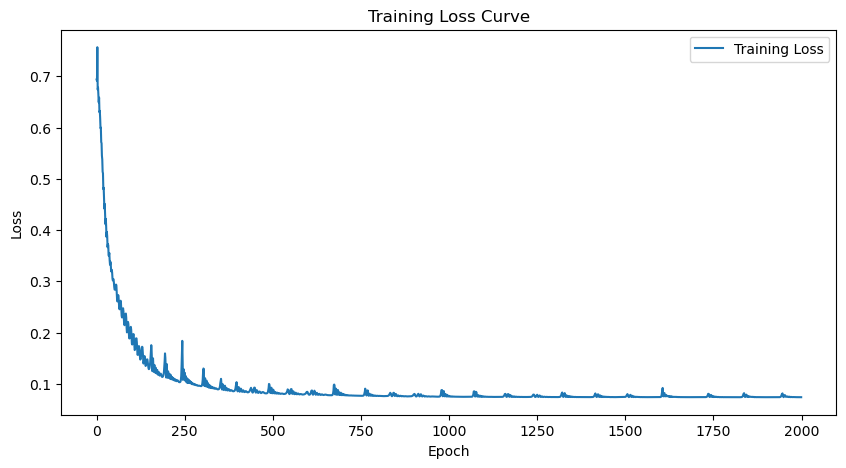

Final Model Accuracy: 83.16%
Final Model F1-score: 0.8431


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'.


In [11]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.91      0.74      0.82       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.83       380



/tmp/ipykernel_226087/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
